In [1]:
# Import PyTorch
import torch
from torch import nn
torch.manual_seed(42)
# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")
device = torch.device('cuda:0')

PyTorch version: 2.8.0+cu129
torchvision version: 0.23.0+cu129


In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [3]:
class_names = train_data.classes

In [4]:
img, label = train_data[0]
print('Channel - Height - Width')
print(img.shape, label) 

Channel - Height - Width
torch.Size([1, 28, 28]) 9


In [5]:
print(len(train_data.data),len(train_data.targets),len(test_data.data),len(test_data.targets))
print('60k dữ liệu train và 10k dữ liệu test')

60000 60000 10000 10000
60k dữ liệu train và 10k dữ liệu test


In [6]:
from torch.utils.data import DataLoader
bs = 64
train_DL = DataLoader(train_data, batch_size=bs, shuffle = True)
test_DL = DataLoader(test_data, batch_size=bs)

In [7]:
for X,y in train_DL :
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [8]:
class MNIST_v0(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.flatten = nn.Flatten()
        self.forward_pass = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self, X) :
        X = self.flatten(X)
        return self.forward_pass(X)

In [9]:
model_0 = MNIST_v0()
model_0.to(device)

MNIST_v0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (forward_pass): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [10]:
img = img.to(device)
logits = model_0(img)
preds = torch.softmax(logits, 1)
preds, preds.max(1), preds.argmax(1), label

(tensor([[0.0986, 0.0940, 0.0944, 0.1007, 0.1048, 0.1038, 0.1079, 0.1009, 0.0994,
          0.0955]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 torch.return_types.max(
 values=tensor([0.1079], device='cuda:0', grad_fn=<MaxBackward0>),
 indices=tensor([6], device='cuda:0')),
 tensor([6], device='cuda:0'),
 9)

In [11]:
from torchmetrics import Accuracy, F1Score, Precision, Recall, AUROC
accuracy = Accuracy(task = 'multiclass',num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optim0 = torch.optim.Adam(params=model_0.parameters(), lr = 0.003)
f1 = F1Score(task = 'multiclass', average='macro', num_classes=10).to(device)
precision = Precision(task='multiclass', num_classes=10)

In [12]:
len(train_DL)

938

In [30]:
def train_loop(model, dataloader, loss_fn, optim): 
    model.train()
    accuracy.reset()
    batch_num = len(dataloader)
    for batch, (X,y) in enumerate(dataloader) :
        X,y = X.to(device), y.to(device)
        preds = model(X) 
        loss = loss_fn(preds, y) 

        optim.zero_grad()
        loss.backward()
        optim.step()

        accuracy.update(preds.argmax(1), y)
        if (batch%400==0) :
            acc = accuracy.compute()
            print(f'Batch {batch}/{batch_num} || Train loss: {loss} || Accuracy: {acc}')
            
def test_loop(model, dataloader, loss_fn):
    model.eval()
    f1.reset()
    batch_num = len(dataloader)
    total_loss = 0
    with torch.inference_mode():
        for X,y in dataloader: 
            X,y = X.to(device), y.to(device)
            preds = model(X)
            total_loss+=loss_fn(preds, y).item()
            f1.update(preds.argmax(1), y)
    acc = f1.compute()
    loss = total_loss/batch_num
    print(f"Loss: {loss} || accuracy: {acc}")

In [14]:
# epochs = 3
# for epoch in range(epochs): 
#     train_loop(model_0, train_DL, loss_fn, optim0)
#     test_loop(model_0, test_DL, loss_fn)

##### ***TẠO HÀM ĐÁNH GIÁ MODEL***


In [16]:
def model_eval(model, dataloader, loss_fn) :
    model.eval()
    f1.reset()
    total_loss = 0
    with torch.inference_mode():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            preds = model(X)
            total_loss+=loss_fn(preds, y).item()
            f1.update(preds.argmax(1), y)
    loss = total_loss/len(dataloader)
    acc = f1.compute()
    return str(f"{model}\nSai so: {loss}\nDo chinh xac: {acc}")

In [17]:
print(model_eval(model_0, test_DL, loss_fn))

MNIST_v0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (forward_pass): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Sai so: 2.3076792871876126
Do chinh xac: 0.02607293799519539


### ***XÂY DỰNG MẠNG NEURON TÍCH CHẬP ĐẦU TIÊN TRONG ĐỜI***

In [18]:
# Create a convolutional neural network 
class tinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
                    #               1                  10                 10 
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, # số lượng filter - đặc trưng 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units+5, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units+5, hidden_units+5, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=(hidden_units+5)*7*7,  
                      out_features=10)
        ) #ảnh vào 28x28, sau 2 lớp pooling 2 còn 14x14 -> 7x7
          #vì lớp conv cuối cùng trả về hidden units -> sau khi flatten() nó có 10*7*7 entries
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)


In [19]:
model_1 = tinyVGG(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names))
model_1.to(device)

tinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=735, out_features=10, bias=True)
  )
)

In [20]:
optim1 = torch.optim.Adam(params=model_1.parameters(), lr = 0.002)

In [29]:
epochs = 3
for epoch in range(epochs): 
    train_loop(model_1, train_DL, loss_fn, optim1)
    test_loop(model_1, test_DL, loss_fn)

AttributeError: 'Softmax' object has no attribute 'max'

In [ ]:
for batch,(X,y) in enumerate(train_DL) :
    X,y = X.to(device), y.to(device)
    print(X.shape, y.shape)
    print(model_1(X).shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


In [ ]:
print(model_eval(model_0, test_DL, loss_fn))
print(model_eval(model_1, test_DL, loss_fn))

MNIST_v0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (forward_pass): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Sai so: 2.3076792871876126
Do chinh xac: 0.02607293799519539
tinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    

#### ***DÙNG MLXTEND ĐỂ PLOT CONFUSION MATRIX***

In [33]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in test_DL:
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

In [ ]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


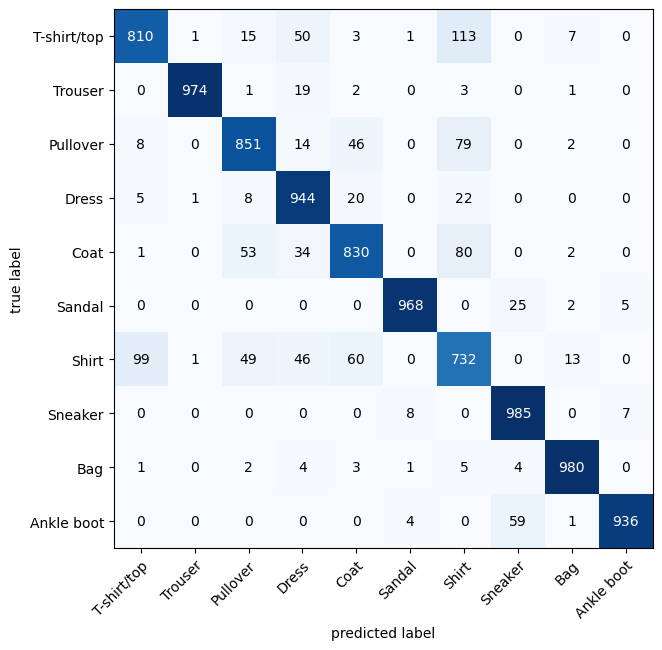

In [ ]:
# from torchmetrics import ConfusionMatrix
# from mlxtend.plotting import plot_confusion_matrix

# # 2. Setup confusion matrix instance and compare predictions to targets
# confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
# confmat_tensor = confmat(preds=y_pred_tensor,
#                          target=test_data.targets)

# # 3. Plot the confusion matrix
# fig, ax = plot_confusion_matrix(
#     conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
#     class_names=class_names, # turn the row and column labels into class names
#     figsize=(10, 7)
# )

In [35]:
y_pred_tensor[:10], test_data.targets[:10]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]),
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]))

In [32]:
model = tinyVGG(1, 10, 10)
model.load_state_dict(torch.load(f = MODEL_SAVE_PATH, weights_only=True))
model.to(device)

tinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=735, out_features=10, bias=True)
  )
)

In [ ]:
print(model_eval(model, test_DL, loss_fn))    

tinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=735, out_features=10, bias=True)
  )
)
Sai so: 0.27832608451699
Do chinh xac: 0.9010884165763855


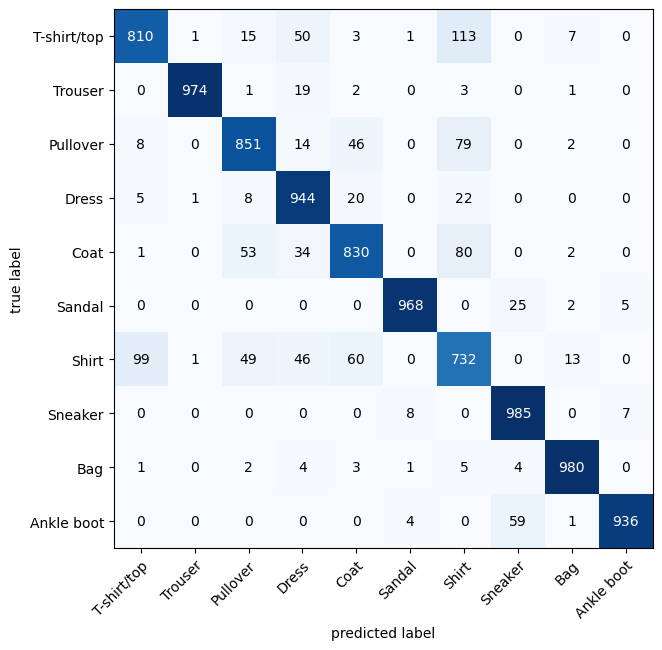

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=10, task = 'multiclass')
confmat_tensor = confmat(y_pred_tensor, test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10,7)
)
